In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-07-22 02:15:42.735929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 02:15:42.852857: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 02:15:42.880300: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4) doesn't match a supporte

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print(x_train.shape)

(60000, 28, 28)


In [4]:
x_train=tf.expand_dims(x_train, axis=3)

2025-07-22 02:15:44.824300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 02:15:45.248961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22294 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6


In [5]:
x_train = tf.image.resize(x_train, (224,224))

In [17]:
x_test = tf.expand_dims(x_test, axis=-1)

In [18]:
x_test = tf.image.resize(x_test, (224,224))

In [19]:
x_test.shape

TensorShape([10000, 224, 224, 1])

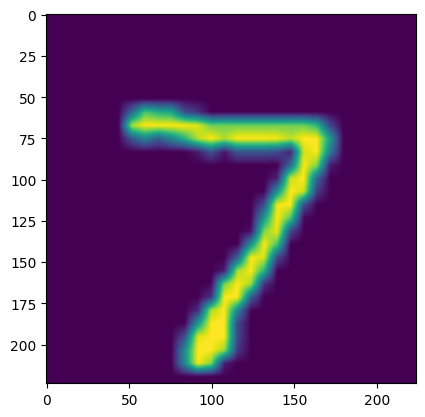

In [20]:
plt.imshow(x_test[0])

In [8]:
class Inception_module(tf.keras.layers.Layer):
    def __init__(self, filter1, filter2r, filter2, filter3r, filter3, filter4r):
        super(Inception_module, self).__init__()
        self.filter1 = filter1
        
        self.filter2 = filter2
        self.filter2r = filter2r
        
        self.filter3 = filter3
        self.filter3r = filter3r
        
        self.filter4r = filter4r
        
        # self.kernel_size = kernel_size
        # self.stride = stride
        
        # 1x1 conv
        self.conv1 = tf.keras.layers.Conv2D(filters=self.filter1,
                                            kernel_size=(1,1),
                                            strides=1,
                                            padding='same',
                                            activation='relu'
                                           )
        
        # 1x1 conv(dimension reduction) -> 3x3 conv
        self.conv2r = tf.keras.layers.Conv2D(filters=self.filter2r,
                                             kernel_size=(1,1),
                                             strides=1,
                                             padding='same',
                                             activation='relu'
                                            )
        self.conv2 = tf.keras.layers.Conv2D(filters=self.filter2,
                                            kernel_size=(3,3),
                                            strides=1,
                                            padding='same',
                                            activation='relu'
                                           )
        
        # 1x1 conv(dimension reduction) -> 5x5 conv
        self.conv3r = tf.keras.layers.Conv2D(filters=self.filter3r,
                                             kernel_size=(1,1),
                                             strides=1,
                                             padding='same',
                                             activation='relu'
                                            )
        self.conv3 = tf.keras.layers.Conv2D(filters=self.filter3,
                                           kernel_size=(5,5),
                                           strides=1,
                                           padding='same',
                                            activation='relu'
                                           )
        
        # maxpool-> 1x1 conv(dimension reduction)
        self.MaxPool = tf.keras.layers.MaxPool2D(pool_size=(3,3),
                                                 strides=1,
                                                padding='same')
        self.MaxPoolr = tf.keras.layers.Conv2D(filters=self.filter4r,
                                               kernel_size=(1,1),
                                               strides=1,
                                               padding='same',
                                               activation='relu'
                                              )
        
        
    def build(self, input_shape):
        self.batch, self.height, self.width, self.channel = input_shape
    
    
    def call(self, inputs):
        # 1x1 conv, stride=1
        x_1=self.conv1(inputs)
        
        # 1x1 conv -> 3x3 conv
        x_3r=self.conv2r(inputs)
        x_3=self.conv2(x_3r)
        
        # 1x1 conv -> 5x5 conv
        x_5r=self.conv3r(inputs) 
        x_5=self.conv3(x_5r)
        
        # 3x3 max pool -> 1x1 conv
        x_pool=self.MaxPool(inputs)
        x_poolr=self.MaxPoolr(x_pool)
        
        # inception_output
        output = tf.keras.layers.concatenate([x_1, x_3, x_5, x_poolr])
        # output = tf.concat([x_1, x_3, x_5, x_poolr])
        
        return output 

In [9]:
class auxiliary_classifier(tf.keras.layers.Layer):
    def __init__(self, class_num):
        super(auxiliary_classifier, self).__init__()
        self.num = class_num
        self.avgpool = tf.keras.layers.AveragePooling2D(pool_size=(5,5), strides=3)
        self.conv = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024, activation='relu') 
        self.dropout = tf.keras.layers.Dropout(0.7)
        self.dense2 = tf.keras.layers.Dense(self.num, activation='softmax')
        
    def build(self, input_shape):
        self.batch, self.height, self.width, self.channel = input_shape
    
    def call(self, inputs):
        x=self.avgpool(inputs)
        x=self.conv(x)
        x=self.flatten(x)
        x=self.dense1(x)
        x=self.dropout(x)
        output=self.dense2(x)
        
        return output 

In [10]:
inputs=tf.keras.layers.Input((224,224,1))

x=inputs
x=tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=2,padding='same', activation='relu')(x)
# print(x.shape)
x=tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2,padding='same')(x)
# print(x.shape)
# x=tf.nn.local_response_normalization(x)
x=tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
x=tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
# print(x.shape)
# x=tf.nn.local_response_normalization(x)


x=tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)
# print(x.shape)

x=Inception_module(64, 96, 128, 16, 32, 32)(x)
x=Inception_module(128,128,192,32,96,64)(x)

x=tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)
# print(x.shape)

x=Inception_module(192,96,208,16,48,64)(x)

# Auxiliary classifier
softmax0=auxiliary_classifier(10)(x)

x=Inception_module(160,112,224,24,64,64)(x)

x=Inception_module(128,128,256,24,64,64)(x)
x=Inception_module(112,144,288,32,64,64)(x)

# Auxiliary classifier
softmax1=auxiliary_classifier(10)(x)

x=Inception_module(256,160,320,32,128,128)(x)

x=tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)
# print(x.shape)

x=Inception_module(256,160,320,32,128,128)(x)
x=Inception_module(384,192,384,48,128,128)(x)

x=tf.keras.layers.AveragePooling2D(pool_size=(7,7), strides=1)(x)
x=tf.keras.layers.Dropout(0.4)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)

softmax2=tf.keras.layers.Dense(10, activation='softmax')(x)
print(softmax2.shape)

model=tf.keras.Model(inputs=inputs, outputs=[softmax0, softmax1, softmax2])

(None, 10)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={
                  'auxiliary_classifier': tf.keras.losses.SparseCategoricalCrossentropy(),
                  'auxiliary_classifier_1': tf.keras.losses.SparseCategoricalCrossentropy(),
                  'dense_5': tf.keras.losses.SparseCategoricalCrossentropy()
              },
              loss_weights={
                  'auxiliary_classifier': 0.3,
                  'auxiliary_classifier_1': 0.3,
                  'dense_5': 1.0
              },
              metrics={
                  'auxiliary_classifier': tf.keras.metrics.SparseCategoricalAccuracy(),
                  'auxiliary_classifier_1': tf.keras.metrics.SparseCategoricalAccuracy(),
                  'dense_5': tf.keras.metrics.SparseCategoricalAccuracy()
              }
             )

In [14]:
y_train_dict={
        'auxiliary_classifier': y_train,
        'auxiliary_classifier_1': y_train,
        'dense_5': y_train
}

In [15]:
model.fit(x_train,
          y_train_dict,
          batch_size=16,
          epochs=10)

Epoch 1/10


2025-07-22 02:17:04.973422: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-07-22 02:17:06.069942: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3750/3750 [==============================] - 90s 23ms/step - loss: 0.4552 - auxiliary_classifier_loss: 0.2251 - auxiliary_classifier_1_loss: 0.2332 - dense_5_loss: 0.3178 - auxiliary_classifier_sparse_categorical_accuracy: 0.9303 - auxiliary_classifier_1_sparse_categorical_accuracy: 0.9254 - dense_5_sparse_categorical_accuracy: 0.8951
Epoch 2/10
3750/3750 [==============================] - 86s 23ms/step - loss: 0.1271 - auxiliary_classifier_loss: 0.0791 - auxiliary_classifier_1_loss: 0.0723 - dense_5_loss: 0.0817 - auxiliary_classifier_sparse_categorical_accuracy: 0.9770 - auxiliary_classifier_1_sparse_categorical_accuracy: 0.9793 - dense_5_sparse_categorical_accuracy: 0.9779
Epoch 3/10
3750/3750 [==============================] - 85s 23ms/step - loss: 0.1003 - auxiliary_classifier_loss: 0.0627 - auxiliary_classifier_1_loss: 0.0593 - dense_5_loss: 0.0637 - auxiliary_classifier_sparse_categorical_accuracy: 0.9821 - auxiliary_classifier_1_sparse_categorical_accuracy: 0.9832 - dense_5_spa

In [21]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 13ms/step - loss: 0.0416 - auxiliary_classifier_loss: 0.0206 - auxiliary_classifier_1_loss: 0.0222 - dense_5_loss: 0.0288 - auxiliary_classifier_sparse_categorical_accuracy: 0.9936 - auxiliary_classifier_1_sparse_categorical_accuracy: 0.9930 - dense_5_sparse_categorical_accuracy: 0.9917


[0.041587959975004196,
 0.020567381754517555,
 0.022159969434142113,
 0.028769753873348236,
 0.9936000108718872,
 0.9929999709129333,
 0.9916999936103821]